In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pydot
import os
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter
import scene
import AllegroWrapper
import contact
import motion_planning
import search
import visualizations
from pydrake.all import StartMeshcat, RigidTransform, RotationMatrix
from manipulation.utils import ConfigureParser

In [2]:
meshcat = None

In [3]:
p_W_brick = [0.6, -0.3, 0.015] #[np.random.uniform(0.4, 0.75), np.random.uniform(-0.35, 0.35), 0.01]
R_W_brick = [0, 0, np.random.randint(0, 360)]
meshcat, station, simulator, context, p_W_brick, R_W_brick = scene.init_scenario(brick_location=p_W_brick, brick_rotation=R_W_brick, meshcat=meshcat)

allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
# scene.render_station_diagram(station)

def reset_arm(station, simulator, context, x0):
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

reset_arm(station, simulator, context, x0)

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [5]:
def investigate(simulator, station, p_W_obj, all_touched_points):
    """
    Given contact with an object, sample a number of contact locations nearby and 
    plan a trajectory with a finger to the object, in order to build up a point cloud
    of the object for pose estimation
    """
    context = simulator.get_mutable_context()   
    plant = station.GetSubsystemByName("plant")
    gripper = plant.GetBodyByName("hand_root") # tip of the index finger
    plant_context = plant.GetMyContextFromRoot(context)

    def raise_hand(amount):
        iiwa_body = plant.GetBodyByName("hand_root")
        X_WG = plant.EvalBodyPoseInWorld(plant_context, iiwa_body)

        start_pos = np.array(X_WG.translation())
        end_pos = start_pos + np.array([0, 0, amount])
        print(start_pos, end_pos)
        # Linear interpolation in Z-axis
        interp_positions = np.linspace(start_pos, end_pos, 5)
        print(interp_positions)
        # Generate list of RigidTransform objects
        pose_list = [RigidTransform(X_WG.rotation(), pos) for pos in interp_positions]

        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(end_pos, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                poses=pose_list,
                                                frame="hand_root", 
                                                arc_height=0.2,
                                                stop_on_contact=False,
                                                freeze_fingers=False,
                                                position_tol=np.array([0.1, 0.1, 0.01])
                                                )
        print("Raised arm up!")
        return None

    raise_hand(.2)
    simulator.AdvanceTo(context.get_time() + 1)

    num_samples = 20
    nearby_x = np.random.uniform(p_W_obj[0] - 0.05, p_W_obj[0] + 0.05, num_samples)
    nearby_y = np.random.uniform(p_W_obj[1] - 0.05, p_W_obj[1] + 0.05, num_samples)
    nearby_z = np.ones(num_samples) * p_W_obj[2]

    nearby_points = np.vstack((nearby_x, nearby_y, nearby_z)).T
    for point in nearby_points:
        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(point, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame="link_2", 
                                                arc_height=0.2,
                                                stop_on_contact=True,
                                                freeze_fingers=False,
                                                state_update_len=23,
                                                simulator_steps=100,
                                                position_tol=[0.01, 0.01, 0.01])
        for contact in new_contacts:
            all_touched_points.add(tuple(contact))   

        # raise_hand(0.5)
        simulator.AdvanceTo(context.get_time() + .25)
        
    return all_touched_points

In [6]:
def run_search(station, frame = "hand_root", object_bias=None):
    reset_arm(station, simulator, context, x0)
    plant = station.GetSubsystemByName("plant")
    all_touched_points = set()

    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    
    X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = contact.get_table_contact(X_WG)
    p_WG_post = table_end_effector_poses[-1].translation()
       
    obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(p_WG_post, simulator, station, context, time_interval=0.4, frame=frame)
    touch_history = []

    if obj_touched == "table":
        table_height = min(new_contacts[:, 2])
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
        print("Table height: ", table_height)
    else:
        print("Table not found")

    touch_history.append(touched_point[:2])
    for point in new_contacts:
        all_touched_points.add(tuple(point))

    i = 0
    while obj_touched != "object":
        if i > 30:
            break
        i += 1
        
        next_touch = search.sample_new_target(touch_history, bias_position=object_bias, object_radius=0.03)
        next_point = [next_touch[0], next_touch[1], table_height]
        touch_history.append(next_touch)
        
        #next_point = p_W_brick
        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)

        # NOTE: This can change if there's biases in the search algorithm, based on the object's height and expected distance from the gripper
        # NOTE: We might also modify it based on some energy constraint, to minimize movement costs
        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(next_point, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                frame=frame, 
                                                stop_on_contact=True,
                                                arc_height=0.2)
                                                
        for point in new_contacts:
            all_touched_points.add(tuple(point))

        X_WG = plant.EvalBodyPoseInWorld(plant_context, gripper)
        #fig = visualizations.plot_2d_search(X_WG.translation(), all_touched_points, next_touch, object_bias, p_W_brick)
        #plt.show()

    print("Object found! Location at: ", p_W_obj)
    print("Actual object location: ", p_W_brick)
    print("Difference: ", np.linalg.norm(np.array(p_W_obj)[:2] - np.array(p_W_brick[:2])))
    return all_touched_points, p_W_obj

all_touched_points, object_contact = run_search(station, object_bias=[p_W_brick[0], p_W_brick[1]])

Table height:  -0.0005481044961132379
Object found! Location at:  [ 0.61554279 -0.27478185  0.04874894]
Actual object location:  [0.6, -0.3, 0.015]
Difference:  0.02962319112654896


In [7]:
# reset_arm(station, simulator, context, x0)
# allegro.set_positions(["thumb_revolute_z"], [1.0])


In [8]:
all_touched_points = investigate(simulator, station, object_contact, all_touched_points)

[ 0.61811263 -0.22195504  0.05120234] [ 0.61811263 -0.22195504  0.25120234]
[[ 0.61811263 -0.22195504  0.05120234]
 [ 0.61811263 -0.22195504  0.10120234]
 [ 0.61811263 -0.22195504  0.15120234]
 [ 0.61811263 -0.22195504  0.20120234]
 [ 0.61811263 -0.22195504  0.25120234]]
Raised arm up!


In [9]:
p_WC = np.array(list(all_touched_points))
p_WC[np.where(p_WC[:, 2] > 0.01)]

array([[ 0.64472937, -0.28855893,  0.04893513],
       [ 0.64461625, -0.28862616,  0.04904841],
       [ 0.60236364, -0.2693819 ,  0.04906034],
       [ 0.63251734, -0.31515526,  0.04900669],
       [ 0.64462956, -0.28863196,  0.04903859],
       [ 0.64470303, -0.28857633,  0.04895829],
       [ 0.64471522, -0.28856995,  0.04894798],
       [ 0.64469249, -0.28858033,  0.04896994],
       [ 0.6445744 , -0.28882987,  0.048976  ],
       [ 0.64461269, -0.28863032,  0.04905256],
       [ 0.64461056, -0.28863723,  0.04905575],
       [ 0.6447656 , -0.28853045,  0.0489099 ],
       [ 0.64473313, -0.28855777,  0.04893187],
       [ 0.64474538, -0.28854814,  0.04892273],
       [ 0.6182588 , -0.27561848,  0.04655889]])

[[ 0.64472937 -0.28855893  0.04893513]
 [ 0.64461625 -0.28862616  0.04904841]
 [ 0.60236364 -0.2693819   0.04906034]
 [ 0.63251734 -0.31515526  0.04900669]
 [ 0.64462956 -0.28863196  0.04903859]
 [ 0.64470303 -0.28857633  0.04895829]
 [ 0.64471522 -0.28856995  0.04894798]
 [ 0.64469249 -0.28858033  0.04896994]
 [ 0.6445744  -0.28882987  0.048976  ]
 [ 0.64461269 -0.28863032  0.04905256]
 [ 0.64461056 -0.28863723  0.04905575]
 [ 0.6447656  -0.28853045  0.0489099 ]
 [ 0.64473313 -0.28855777  0.04893187]
 [ 0.64474538 -0.28854814  0.04892273]
 [ 0.6182588  -0.27561848  0.04655889]]


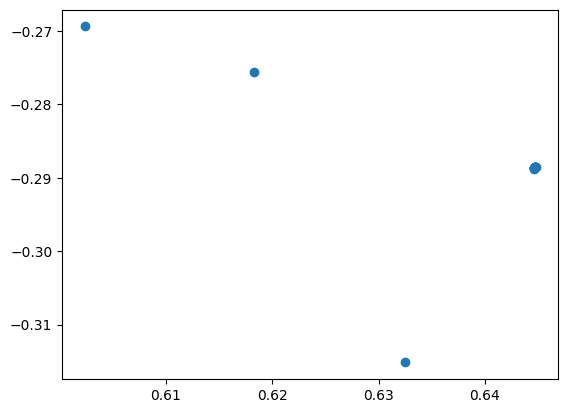

In [10]:
pc = np.array(list(all_touched_points))
box_points = pc[np.where(pc[:, 2] > 0.01)]
print(box_points)
plt.scatter(box_points[:, 0], box_points[:, 1])

In [11]:
def fit_plane_to_points(points):
    """
    Fits a plane to a set of points using PCA and returns the plane's normal.

    Args:
        points (np.array): Nx3 array of 3D points.

    Returns:
        normal (np.array): The normal vector of the fitted plane.
    """

    centroid = np.mean(points, axis=0)
    centered_points = points - centroid
    covariance_matrix = np.cov(centered_points.T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # The normal of the plane is the eigenvector corresponding to the smallest eigenvalue
    sorted_indices = np.argsort(np.abs(eigenvalues)) 
    max_eigenvectors = eigenvectors[:, sorted_indices[-2:]]

    return max_eigenvectors

In [12]:
x_est_W = np.mean(box_points[:, 0])
y_est_W = np.mean(box_points[:, 1])
z_est_W = np.mean(box_points[:, 2])
print("Estimated object location: ", x_est_W, y_est_W, z_est_W)

# Estimate Orientation by fitting a plane to the points
orientation = fit_plane_to_points(box_points).T
print(orientation.shape)
x1, y1 = orientation[0][:2]
x2, y2 = orientation[1][:2]
angle = np.rad2deg(np.arctan((y2 - y1) / (x2 - x1))) + 180

print("Estimated angle: ", angle)


Estimated object location:  0.6392844977885105 -0.28822887079170384 0.04882487122264333
(2, 3)
Estimated angle:  195.42211971271632


In [13]:
print("Actual position and Angle: ", p_W_brick, R_W_brick)

Actual position and Angle:  [0.6, -0.3, 0.015] [0, 0, 3]


In [14]:
# allegro.close_hand()
# simulator.AdvanceTo(context.get_time() + 1)
                                            

In [15]:
# allegro.open_hand()
# simulator.AdvanceTo(context.get_time() + 1)


In [16]:
frame = "hand_root"
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(context)
world_frame = plant.world_frame()
X_WG = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName(frame))


In [17]:
def raise_hand(amount):
        iiwa_body = plant.GetBodyByName("hand_root")
        X_WG = plant.EvalBodyPoseInWorld(plant_context, iiwa_body)

        start_pos = np.array(X_WG.translation())
        end_pos = start_pos + np.array([0, 0, amount])
        print(start_pos, end_pos)
        # Linear interpolation in Z-axis
        interp_positions = np.linspace(start_pos, end_pos, 5)
        print(interp_positions)
        # Generate list of RigidTransform objects
        pose_list = [RigidTransform(X_WG.rotation(), pos) for pos in interp_positions]

        obj_touched, new_contacts, p_W_obj = motion_planning.move_arm(end_pos, 
                                                simulator, 
                                                station, 
                                                context, 
                                                time_interval=0.4, 
                                                poses=pose_list,
                                                frame="hand_root", 
                                                arc_height=0.2,
                                                stop_on_contact=False,
                                                freeze_fingers=False,
                                                position_tol=np.array([0.1, 0.1, 0.01])
                                                )

In [21]:
raise_hand(0.2)

# Open hand
allegro.open_hand()
simulator.AdvanceTo(context.get_time() + .5)
allegro.set_positions(["thumb_revolute_z", "thumb_revolute_y", "thumb_1", "thumb_2"], [1.5, .9, 1.2, 0.5])
simulator.AdvanceTo(context.get_time() + .5)


# Position Hand in pre-grasp mode
R_WG = X_WG.rotation()
X_Wbrick_estimated = RigidTransform(RotationMatrix().MakeZRotation(angle), [x_est_W, y_est_W, z_est_W])

X_BG = X_Wbrick_estimated.inverse().multiply(copy.deepcopy(X_WG))
offset_BGripper = np.array([-0.05, 0.0, 0.05])
p_BG_pre = X_BG.translation() + offset_BGripper
R_BG_pre = X_BG.rotation().MakeXRotation(np.pi / 2).MakeYRotation(np.pi / 2)

X_BG_pre = RigidTransform(R_BG_pre, p_BG_pre)
X_WG_pre = X_Wbrick_estimated.multiply(X_BG_pre)

pose_list = [X_WG_pre]

_, _, _ = motion_planning.move_arm(None, 
                                    simulator, 
                                    station, 
                                    context, 
                                    poses=pose_list,
                                    time_interval=1, 
                                    frame=frame, 
                                    stop_on_contact=False,
                                    arc_height=0.2)


# Move hand down
X_WG_pick = copy.deepcopy(X_WG_pre)
X_WG_pick.set_translation(X_WG_pick.translation() + np.array([0, 0, -0.1]))
pose_list = [X_WG_pick]

simulator.AdvanceTo(context.get_time() + 1)
_, _, _ = motion_planning.move_arm(None, 
                                    simulator, 
                                    station, 
                                    context, 
                                    poses=pose_list,
                                    time_interval=1, 
                                    frame=frame, 
                                    arc_height=0.2
                                )
simulator.AdvanceTo(context.get_time() + 1)


[ 0.43253328 -0.32879114  0.12829914] [ 0.43253328 -0.32879114  0.32829914]
[[ 0.43253328 -0.32879114  0.12829914]
 [ 0.43253328 -0.32879114  0.17829914]
 [ 0.43253328 -0.32879114  0.22829914]
 [ 0.43253328 -0.32879114  0.27829914]
 [ 0.43253328 -0.32879114  0.32829914]]


In [25]:

# Close hand
simulator.AdvanceTo(context.get_time() + 1)
allegro.close_hand()
simulator.AdvanceTo(context.get_time() + 1)
allegro.tighten_hand()
simulator.AdvanceTo(context.get_time() + 1)
X_WG_post = copy.deepcopy(X_WG_pick)
X_WG_post.set_translation(X_WG_post.translation() + np.array([0, 0, 0.05]))
pose_list = [X_WG_post]

# allegro.tighten_hand()
# simulator.AdvanceTo(context.get_time() + 1)

# Try and pick the fucker up
_, _, _ = motion_planning.move_arm(None, 
                                    simulator, 
                                    station, 
                                    context, 
                                    poses=pose_list,
                                    time_interval=1, 
                                    frame=frame, 
                                    arc_height=0.2)
simulator.AdvanceTo(context.get_time() + 1)                                   